In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numba
import numpy as np
from scipy import sparse
from scipy.fftpack import dct

In [2]:
def hamiltonian(N, t=1, mu=0):
    """Construct the Hamiltonian matrix for a simple 2D tight-binding model."""
    H = np.zeros(5*N**2)
    i = np.zeros(5*N**2, int)
    j = np.zeros(5*N**2, int)
    ind = np.arange(N**2).reshape(N, N)
    n = 0
    for x, y in np.ndindex(N, N):
        H[n] = -mu
        i[n] = ind[x,y]
        j[n] = ind[x,y]
        n += 1
        
        H[n] = -t
        i[n] = ind[x,y]
        j[n] = ind[(x+1)%N,y]
        n += 1
        
        H[n] = -t
        i[n] = ind[(x+1)%N,y]
        j[n] = ind[x,y]
        n += 1
        
        H[n] = -t
        i[n] = ind[x,y]
        j[n] = ind[x,(y+1)%N]
        n += 1
        
        H[n] = -t
        i[n] = ind[x,(y+1)%N]
        j[n] = ind[x,y]
        n += 1
        
    return sparse.coo_matrix((H, (i, j)), shape=(N**2, N**2))

In [3]:
H = hamiltonian(N=1000)

# Calculate LDOS at (x,y) = (0,0)
v0 = np.zeros(H.shape[0])
v0[0] = 1

omega = np.linspace(-5, 5, 501)
delta = 0.01

# Lanczos method

In [4]:
def tridiagonalize(H, v0, N=100):
    """Calculate the Lanczos tridiagonalization for the starting vector v0.

    H = [
        [a[0], b[1],    0,    0, 0, ...],
        [b[1], a[1], b[2],    0, 0, ...],
        [   0, b[2], a[2], b[3], 0, ...],
        ...
        [0, ..., 0, b[N-2], a[N-2], b[N-1]],
        [0, ..., 0,      0, b[N-1], a[N-1]],
    ]

    Parameters
    ----------
    H : sparse matrix
        Matrix to tridiagonalize.
    v0 : array_like
        Starting vector.
    N : int
        Dimension of Krylov subspace.

    Returns
    -------
    a, b : ndarray
        Diagonal and off-diagonal elements.
    """
    a = np.zeros(N)
    b = np.zeros(N)
    
    # Normalize
    v = v0 / np.linalg.norm(v0)
    # |w> = H |v_0>
    w = H.dot(v)
    # a_0 = <v_0|H|v_0>
    a[0] = np.vdot(v, w).real
    for n in range(1, N):
        # |w> = b_n |v_n>
        w -= a[n-1] * v
        # b = <w|w>**0.5
        b[n] = np.linalg.norm(w)
        # |v_n> = |w> / b_n
        w *= 1/b[n]
        # |v> = -b_n |v_{n-1}>
        v *= -b[n]
        # |v_{n+1}>, |v_n> = |v_n>, |v_{n-1}>
        v, w = w, v
        # |w> = H |v_n> - b_n |v_{n-1}>
        w += H.dot(v)
        # a_n = <v_n|H|v_n> - b_n <v_n|v_{n-1}>
        a[n] = np.vdot(v, w).real
    return a, b


def greens_function(z, a, b):
    """Calculate the Green's function from Lanczos tridiagonalization."""
    G = z - a[-1]
    for n in reversed(range(len(a)-1)):
        G = z - a[n] - b[n+1]**2 / G
    return 1 / G

In [5]:
a, b = tridiagonalize(H, v0, N=1000)
ldos = -greens_function(omega+1j*delta, a, b).imag / np.pi

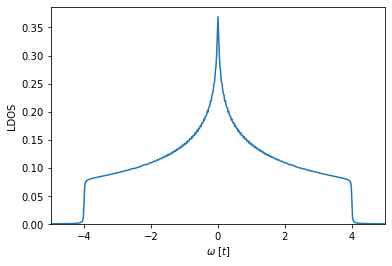

In [6]:
fig, ax = plt.subplots()
ax.plot(omega, ldos)
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel(r'$\omega$ [$t$]')
ax.set_ylabel('LDOS')
plt.show()

In [7]:
@interact(n=(100, len(a)), log_delta=(-5., -1.))
def plot_cutoff(n=1000, log_delta=-2):
    ldos = -greens_function(omega+1j*10**log_delta, a[:n], b[:n]).imag / np.pi

    fig, ax = plt.subplots()
    ax.plot(omega, ldos)
    ax.set_xlim(omega[0], omega[-1])
    ax.set_ylim(0)
    ax.set_xlabel(r'$\omega$ [$t$]')
    ax.set_ylabel('LDOS')
    plt.show()

interactive(children=(IntSlider(value=1000, description='n', max=1000, min=100), FloatSlider(value=-2.0, descr…

# Chebyshev Polynomials

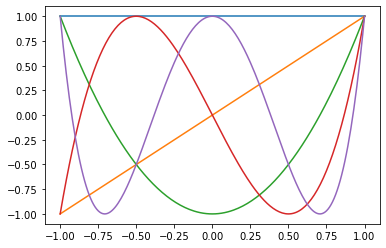

In [8]:
x = np.linspace(-1, 1, 201)
n = np.arange(5)
f = np.cos(n[None,:] * np.arccos(x[:,None]))

fig, ax = plt.subplots()
ax.plot(x, f)
plt.show()

# Kernel polynomial method

In [9]:
def cheby(H, v0, N=100):
    mu = np.empty(N)
    v = v0.copy()
    w = H.dot(v)
    mu[0] = np.linalg.norm(v)**2
    mu[1] = np.vdot(w, v)
    
    n = 2
    while True:
        # |v_{n+1}> = 2H|v_n> - |v_{n-1}>
        v *= -1
        v += 2*H.dot(w)
        
        # μ_{2n} = 2<v_n|v_n> - μ_0
        mu[n] = 2*np.linalg.norm(w)**2 - mu[0]
        n += 1
        if n >= N: break
        
        # μ_{2n+1} = 2<v_{n+1}|v_n> - μ_1
        mu[n] = 2*np.vdot(v, w) - mu[1]
        n += 1
        if n >= N: break

        # |v_{n+1}>, |v_n> = |v_n>, |v_{n-1}>
        w, v = v, w

    return mu


def cheby_DCT(mu, M=0):
    """Calculate the Chebyshev expansion using discrete cosine transform.
    
    f(x) = 1  / (π (1-x^2)^0.5) (μ_0 + 2 Σ_n μ_n T_n(x))
    at x = cos(π (m+1/2)/M)
    
    Parameters
    ----------
    mu : ndarray
        Expansion coefficients.
    M : int
        Number of x points. Default is 2*len(mu).
    
    Returns
    -------
    x : ndarray
        Points.
    f : ndarray
        Function values.
    """
    N = len(mu)
    if M == 0:
        M = 2*N
    m = np.arange(M)
    x = np.cos(np.pi*(m+0.5)/M)
    f = dct(g*mu, n=M, type=3) / (1-x**2)**0.5 / np.pi
    return x, f


@numba.jit
def cheby_FT(mu, M=0):
    """Calculate the Chebyshev expansion using Fourier transform.
    
    f(x) = -i / (1-x^2)^0.5 (μ_0 + 2 Σ_n μ_n exp(-1j*n*arccos(x)))
    at x = cos(π (m+1/2)/M)
    
    Parameters
    ----------
    mu : ndarray
        Expansion coefficients.
    M : int
        Number of x points. Default is 2*len(mu).
    
    Returns
    -------
    x : ndarray
        Points.
    f : ndarray
        Function values.
    """
    N = len(mu)
    if M == 0:
        M = 2*N
    m = np.arange(M)
    x = np.cos(np.pi*(m+0.5)/M)

    λ = np.zeros(M, np.complex128)
    λ[0] = mu[0]
    for n in range(1, N):
        λ[n] = 2*mu[n]*np.exp(-0.5j*np.pi*n/M)

    with numba.objmode(λ='c16[:]'):
        λ = np.fft.fft(λ)
    
    γ = np.zeros(M, np.complex128)
    for m in range(M//2):
        γ[2*m] = λ[m]
        γ[2*m+1] = λ[-m-1].conjugate()
    f = -1j * γ / (1-x**2)**0.5
    return x, f

In [10]:
_a = 8/(2-1e-1)
_b = 0
H_ = (H - _b*sparse.eye(H.shape[0])) / _a

mu = cheby(H_, v0, N=1000)

In [11]:
N = len(mu)
n = np.arange(N)
g = ((N-n+1) * np.cos(np.pi*n/(N+1)) + np.sin(np.pi*n/(N+1)) / np.tan(np.pi/(N+1))) / (N+1)

x, y = cheby_DCT(g*mu)
x, G = cheby_FT(g*mu)

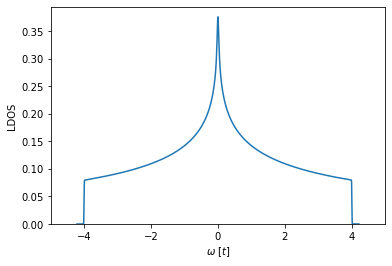

In [12]:
fig, ax = plt.subplots()
ax.plot(_a*x+_b, y/_a)
ax.set_xlim(omega[0], omega[-1])
ax.set_ylim(0)
ax.set_xlabel(r'$\omega$ [$t$]')
ax.set_ylabel('LDOS')
plt.show()

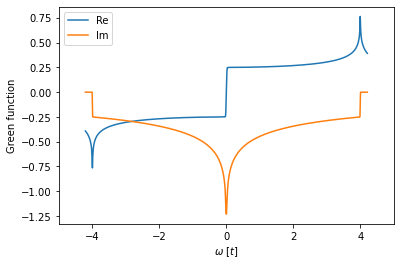

In [13]:
fig, ax = plt.subplots()
ax.plot(_a*x+_b, G.real/_a, label='Re')
ax.plot(_a*x+_b, G.imag/_a, label='Im')
ax.legend()
ax.set_xlim(omega[0], omega[-1])
ax.set_xlabel(r'$\omega$ [$t$]')
ax.set_ylabel('Green function')
plt.show()

In [14]:
@interact(N=(100, len(a)), log_delta=(-5., -1.))
def compare_cutoff(N=500, log_delta=-2):
    delta = 10**log_delta
    ldos = -greens_function(omega+1j*10**log_delta, a[:N], b[:N]).imag / np.pi
    
    n = np.arange(N)
    g1 = ((N-n+1) * np.cos(np.pi*n/(N+1)) + np.sin(np.pi*n/(N+1)) / np.tan(np.pi/(N+1))) / (N+1)
    g2 = np.sinh(delta*(N-n)) / np.sinh(delta*N)

    M = 2*N
    m = np.arange(M)
    x = np.cos(np.pi*(m+0.5)/M)
    y1 = dct(g1*mu[:N], n=M, type=3) / (1-x**2)**0.5 / np.pi
    y2 = dct(g2*mu[:N], n=M, type=3) / (1-x**2)**0.5 / np.pi

    fig, ax = plt.subplots()
    ax.plot(omega, ldos, label='Lanczos')
    ax.plot(_a*x+_b, y1/_a, label='Jackson')
    ax.plot(_a*x+_b, y2/_a, label='Lorentz')
    ax.legend()
    ax.set_xlim(omega[0], omega[-1])
    ax.set_ylim(0, 0.6)
    ax.set_xlabel(r'$\omega$ [$t$]')
    ax.set_ylabel('LDOS')
    plt.show()

interactive(children=(IntSlider(value=500, description='N', max=1000, min=100), FloatSlider(value=-2.0, descri…

# KPM of delta function

In [15]:
N = 200
eps = 1e-3
n = np.arange(N)
mu = np.cos(n*np.pi/2)
g1 = ((N-n+1) * np.cos(np.pi*n/(N+1)) + np.sin(np.pi*n/(N+1)) / np.tan(np.pi/(N+1))) / (N+1)
g2 = np.sinh(eps*(N-n)) / np.sinh(eps*N)

In [16]:
M = 2*N
m = np.arange(M)
x = np.cos(np.pi*(m+0.5)/M)
y = dct(mu, n=M, type=3) / (1-x**2)**0.5 / np.pi
y1 = dct(g1*mu, n=M, type=3) / (1-x**2)**0.5 / np.pi
y2 = dct(g2*mu, n=M, type=3) / (1-x**2)**0.5 / np.pi

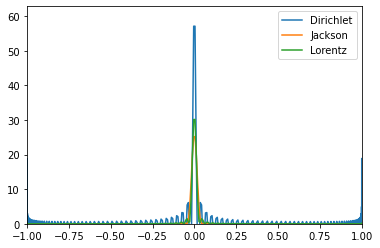

In [17]:
fig, ax = plt.subplots()
ax.plot(x, y, label='Dirichlet')
ax.plot(x, y1, label='Jackson')
ax.plot(x, y2, label='Lorentz')
ax.legend()
ax.set_xlim(-1, 1)
ax.set_ylim(0)
plt.show()

In [18]:
@interact(a=(-1., 1.), N=(100, 1000), λ=(0.01, 5.))
def plot_delta(a=0, N=200, λ=3):
    eps = λ/N
    n = np.arange(N)
    mu = np.cos(n*np.arccos(a))
    g1 = ((N-n+1) * np.cos(np.pi*n/(N+1)) + np.sin(np.pi*n/(N+1)) / np.tan(np.pi/(N+1))) / (N+1)
    g2 = np.sinh(λ*(1-n/N)) / np.sinh(λ)

    M = 10*N
    m = np.arange(M)
    x0 = np.cos(np.pi*(m+0.5)/M)
    y1 = dct(g1*mu, n=M, type=3) / (1-x0**2)**0.5 / np.pi
    y2 = dct(g2*mu, n=M, type=3) / (1-x0**2)**0.5 / np.pi

    var = (N-a**2*(N-1))/(2*(N+1)) * (1-np.cos(2*np.pi/(N+1)))
    sigma = var**0.5
    x = np.linspace(a-5*sigma, a+5*sigma, 400)
    gaussian = np.exp(-(x-a)**2/(2*var)) / (2*np.pi*var)**0.5
    lorentz = eps / np.pi / ((x-a)**2 + eps**2)

    fig, ax = plt.subplots()
    ax.plot(x0, y1, label='Jackson')
    ax.plot(x, gaussian, 'k:', label='Gaussian')
    ax.plot(x0, y2, label='Lorentz')
    ax.plot(x, lorentz, 'k:', label='Lorentzian')
    ax.legend()
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(0)
    plt.show()

interactive(children=(FloatSlider(value=0.0, description='a', max=1.0, min=-1.0), IntSlider(value=200, descrip…